In [2]:
import torch
from torch import nn

# Clasificación

La clasificación es un problema de predicción sobre si algo es una cosa u otra

## Preparación de datos

In [3]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise = 0.03, random_state=42)

print(f"Primeras 5 muestras de X: {X[:5]}")
print(f"Primeras 5 muestras de y: {y[:5]}")

Primeras 5 muestras de X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
Primeras 5 muestras de y: [1 1 1 1 0]


In [4]:
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


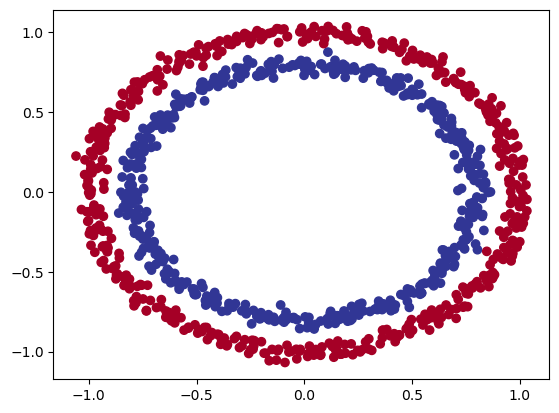

In [5]:
from matplotlib import pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap = plt.cm.RdYlBu)

## Input y output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
X_sample = X[0]
y_sample = y[0]

print(X_sample, y_sample)
print(X_sample.shape, y_sample.shape)
print(type(X))

[0.75424625 0.23148074] 1
(2,) ()
<class 'numpy.ndarray'>


In [8]:
# Pasamos los daros a tensores

import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [9]:
#Split data into training and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)

## Construcción del modelo

Construímos un modelo para clasificar los puntos azules y rojos. Para eso necesitamos:

1) Device agnostic code
2) Construir modelo usando nn.Module
3) Definir loss function y optimizador
4) Crear loop and test loop

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

2) Para construir el modelo:
- Hacemos una clase que herede nn.Module
- Creamos 2 layers de nn.Linear() que sean capaces de manejar los shapes de los datos
- Definimos el método forward()
- Instanciar el modelo

In [11]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
# replicamos usando nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5), 
    nn.Linear(in_features=5, out_features=1)
    ).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
#nueva manera de hacer el modelo:

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        self.two_linear_layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=5), 
            nn.Linear(in_features=5, out_features=1)
        )

    def forward(self, x):
        return self.two_linear_layers(x)
    
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [14]:
model_0.state_dict()

OrderedDict([('two_linear_layers.0.weight',
              tensor([[-0.5545, -0.4762],
                      [ 0.0661,  0.4664],
                      [-0.2925, -0.2013],
                      [ 0.5209, -0.5106],
                      [ 0.5566, -0.6870]])),
             ('two_linear_layers.0.bias',
              tensor([-0.5599,  0.5401, -0.4921,  0.5442,  0.6467])),
             ('two_linear_layers.1.weight',
              tensor([[ 0.2904, -0.2785,  0.3380,  0.4296,  0.1718]])),
             ('two_linear_layers.1.bias', tensor([-0.3177]))])

In [15]:
#make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions: \n{untrained_preds[:10]}")
print(f"\nFirst 10 labels: \n{y_test[:10]}")



Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: 
tensor([[-0.9274],
        [-1.0982],
        [-0.2690],
        [-1.1148],
        [ 0.0654],
        [-0.0414],
        [-0.7874],
        [-0.5391],
        [-0.2841],
        [-1.1059]])

First 10 labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


3) Definir loss function y optimizador

    Qué Loss Function usamos? Para clasificación se usa Binary Cross Entropy o Categorical Cross Entropy

    Como este problema es clasificación binaria, usamos Binary Cross Entropy

In [16]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [17]:
# Calcular precisión

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

#### Logits

Nos referimos a Logits como la salida en crudo de nuestro modelo. Podemos convertirlos en predicciones de probabilidades pasandolos por una función de activación (ejemplos: Sigmoid o Softmax)

Luego los convertimos en predicción de probabilidades a prediction labels al redondearlos o tomando argmax()

Model Output -> Sigmoid activation -> round

In [18]:
model_0.eval()

with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.9274],
        [-1.0982],
        [-0.2690],
        [-1.1148],
        [ 0.0654]])

In [19]:
#sigmoid activation function

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.2835],
        [0.2501],
        [0.4332],
        [0.2470],
        [0.5164]])

In [20]:
y_preds = torch.round(y_pred_probs).squeeze()
y_preds

tensor([0., 0., 0., 0., 1.])

Para la loss function que elegimos hay que pasar los logits, ya que esa función integra el sigmoid y es mas estable.

4) Entrenar modelo: Construir testing y training loop

Train loop:

-   Forward pass
-   Calcular error
-   Optimizer zero grad
-   Loss backward
-   Optimizer step

In [21]:
#training and test loop

torch.manual_seed(42)

epochs = 100

X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Training
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)   #nn.BCEWithLogitsLoss expects raw logits as input
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # Testing

    model_0.eval()

    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f}, Acc: {acc:.2f}% | Test loss: {test_loss:.2f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.74, Acc: 45.12% | Test loss: 0.73, Test acc: 49.50%
Epoch: 10 | Loss: 0.72, Acc: 47.50% | Test loss: 0.71, Test acc: 50.00%
Epoch: 20 | Loss: 0.71, Acc: 48.75% | Test loss: 0.70, Test acc: 50.00%
Epoch: 30 | Loss: 0.71, Acc: 48.38% | Test loss: 0.70, Test acc: 51.50%
Epoch: 40 | Loss: 0.70, Acc: 49.00% | Test loss: 0.69, Test acc: 51.50%
Epoch: 50 | Loss: 0.70, Acc: 49.12% | Test loss: 0.69, Test acc: 51.00%
Epoch: 60 | Loss: 0.70, Acc: 48.75% | Test loss: 0.69, Test acc: 50.50%
Epoch: 70 | Loss: 0.70, Acc: 49.00% | Test loss: 0.69, Test acc: 50.00%
Epoch: 80 | Loss: 0.70, Acc: 49.38% | Test loss: 0.69, Test acc: 50.00%
Epoch: 90 | Loss: 0.70, Acc: 49.38% | Test loss: 0.69, Test acc: 50.00%


### Evaluación del modelo

In [22]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


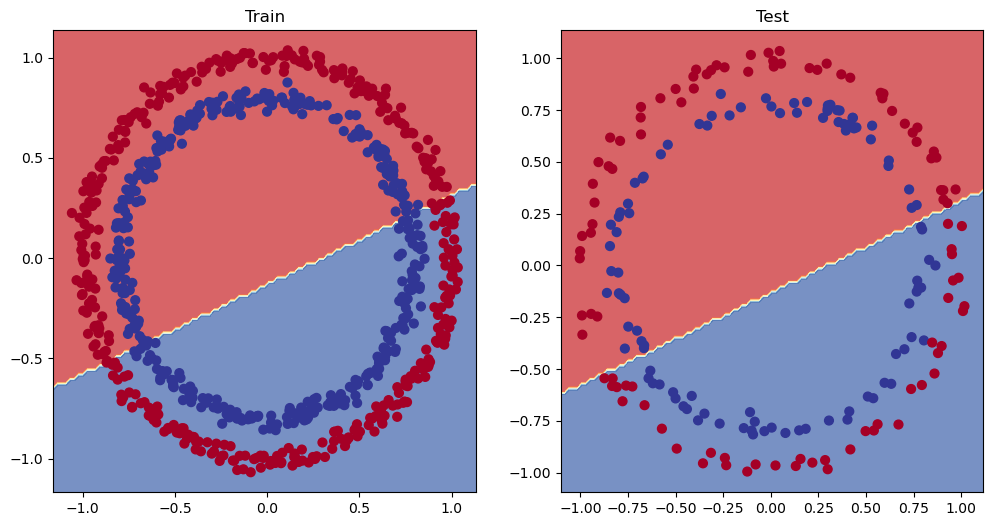

In [23]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

plt.show()

## Mejorando el modelo

Opciones: 
-   Añadir capas
-   Añadir neuronas
-   Cambiar la función de activación
-   Mas epochs
-   Cambiar lr
-   Cambiar loss function

Estas cosas se llaman hiperparámetros ya que son valores que nosotros podemos modificar.

Mejoramos:
-   Añadimos neuronas: 5 -> 10
-   Numero de capas: 2 -> 3
-   Aumentar epochs: 100 -> 1000

Siempre es mejor probar las mejoras una por una en lugar de todas juntas

In [24]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, X):
        z = self.layer_1(X)
        z = self.layer_2(z)
        z = self.layer_3(z)

        return z

In [25]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

#### Entrenamiento y testing

In [26]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

#training and test loop

torch.manual_seed(42)

epochs = 1000

X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Training
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)   #nn.BCEWithLogitsLoss expects raw logits as input
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # Testing

    model_1.eval()

    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f}, Acc: {acc:.2f}% | Test loss: {test_loss:.2f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69, Acc: 50.88% | Test loss: 0.69, Test acc: 51.00%
Epoch: 100 | Loss: 0.69, Acc: 50.38% | Test loss: 0.69, Test acc: 48.00%
Epoch: 200 | Loss: 0.69, Acc: 51.12% | Test loss: 0.69, Test acc: 46.00%
Epoch: 300 | Loss: 0.69, Acc: 51.62% | Test loss: 0.69, Test acc: 45.00%
Epoch: 400 | Loss: 0.69, Acc: 51.12% | Test loss: 0.69, Test acc: 46.00%
Epoch: 500 | Loss: 0.69, Acc: 51.00% | Test loss: 0.69, Test acc: 46.00%
Epoch: 600 | Loss: 0.69, Acc: 51.00% | Test loss: 0.69, Test acc: 46.00%
Epoch: 700 | Loss: 0.69, Acc: 51.00% | Test loss: 0.69, Test acc: 46.00%
Epoch: 800 | Loss: 0.69, Acc: 51.00% | Test loss: 0.69, Test acc: 46.00%
Epoch: 900 | Loss: 0.69, Acc: 51.00% | Test loss: 0.69, Test acc: 46.00%


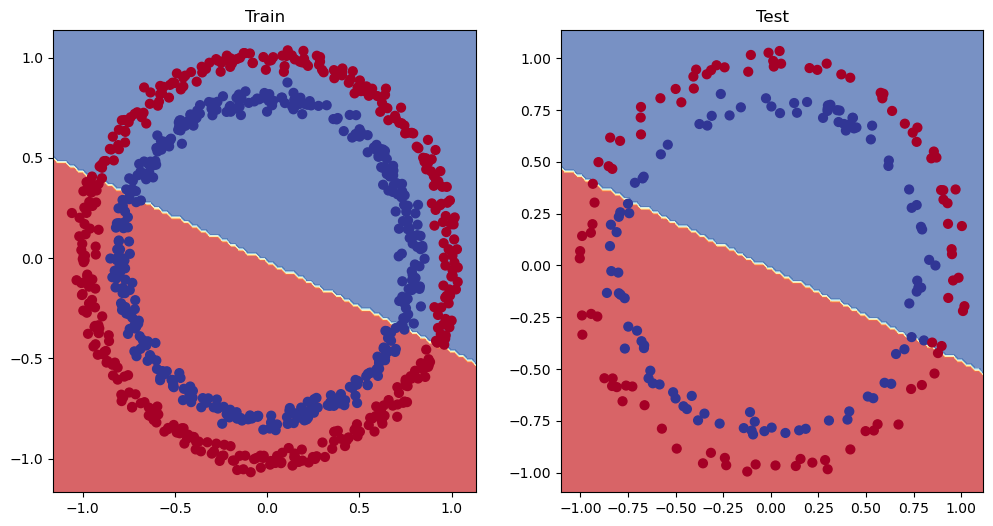

In [27]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

plt.show()

El gráfico muestra las regiones de decisión del modelo, es decir, si el punto ($x_{1}, x_{2}$) está dentro de la región azul, el modelo lo clasificará como que pertenece al grupo 1

El modelo no mejora, así que estudiamos qué está fallando

### Troubleshooting

1) Usamos datos mas simples: una linea recta

In [28]:
weight = 0.7
bias =  0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = X_regression*weight + bias #regresión lineal sin error

train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]


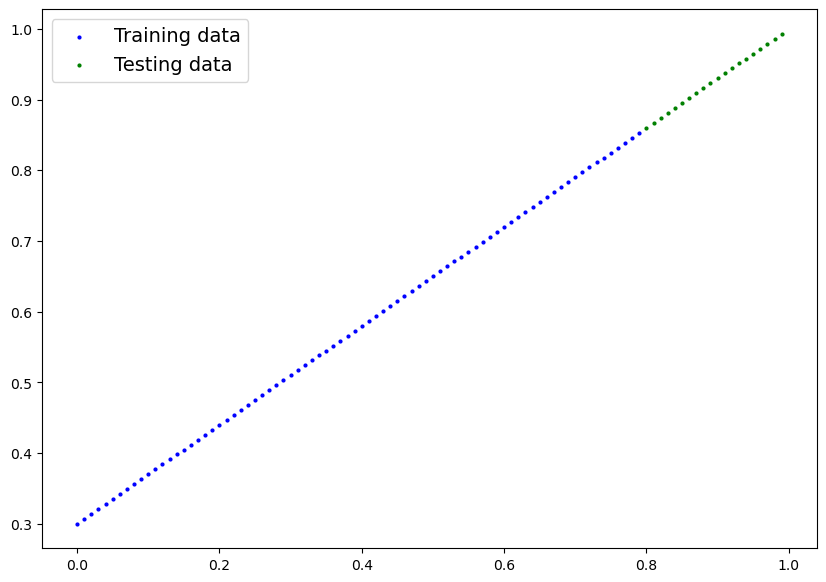

In [29]:
plot_predictions(train_data=X_train_regression, train_labels=y_train_regression, test_data=X_test_regression, test_labels=y_test_regression)

2) Ajustamos el modelo para lineas rectas. Usamos la misma arquitectura pero con nn.Sequential y cambiamos las input features

In [30]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [31]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [32]:
torch.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression,  = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression =  X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    # Training
    model_2.train()

    y_preds = model_2(X_train_regression)

    loss = loss_fn(y_preds, y_train_regression)  

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # Testing

    model_2.eval()

    with torch.inference_mode():
        test_preds = model_2(X_test_regression)
        test_loss = loss_fn(test_preds, y_test_regression)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f} | Test loss: {test_loss:.2f}")

Epoch: 0 | Loss: 0.76 | Test loss: 0.91
Epoch: 100 | Loss: 0.03 | Test loss: 0.00
Epoch: 200 | Loss: 0.03 | Test loss: 0.00
Epoch: 300 | Loss: 0.02 | Test loss: 0.00
Epoch: 400 | Loss: 0.02 | Test loss: 0.00
Epoch: 500 | Loss: 0.02 | Test loss: 0.00
Epoch: 600 | Loss: 0.02 | Test loss: 0.00
Epoch: 700 | Loss: 0.02 | Test loss: 0.00
Epoch: 800 | Loss: 0.02 | Test loss: 0.00
Epoch: 900 | Loss: 0.02 | Test loss: 0.00


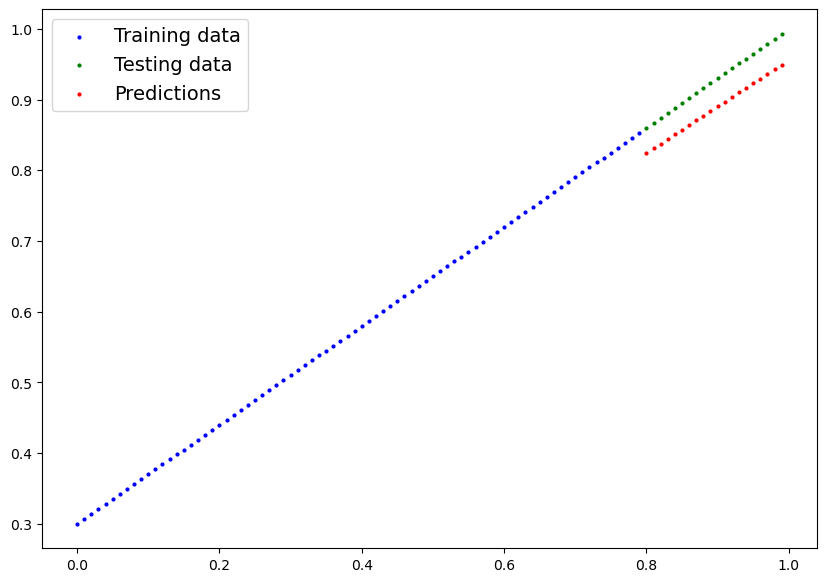

In [33]:
model_2.eval()

with torch.inference_mode():
    y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression, train_labels=y_train_regression, test_data=X_test_regression, test_labels=y_test_regression, predictions=y_preds)

## No linealidad

Construimos un modelo que use capas no lineales.

non-linear activation functions

In [34]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, X):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(X)))))

In [35]:
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [36]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [37]:
torch.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
    model_3.train()
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_3.eval()

    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f}, Acc: {acc:.2f}% | Test loss: {test_loss:.2f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69, Acc: 50.00% | Test loss: 0.69, Test acc: 50.00%
Epoch: 100 | Loss: 0.69, Acc: 52.88% | Test loss: 0.69, Test acc: 52.50%
Epoch: 200 | Loss: 0.69, Acc: 53.37% | Test loss: 0.69, Test acc: 55.00%
Epoch: 300 | Loss: 0.69, Acc: 53.00% | Test loss: 0.69, Test acc: 56.00%
Epoch: 400 | Loss: 0.69, Acc: 52.75% | Test loss: 0.68, Test acc: 56.50%
Epoch: 500 | Loss: 0.68, Acc: 52.75% | Test loss: 0.68, Test acc: 56.50%
Epoch: 600 | Loss: 0.68, Acc: 54.50% | Test loss: 0.67, Test acc: 56.00%
Epoch: 700 | Loss: 0.67, Acc: 58.38% | Test loss: 0.66, Test acc: 59.00%
Epoch: 800 | Loss: 0.65, Acc: 64.00% | Test loss: 0.65, Test acc: 67.50%
Epoch: 900 | Loss: 0.62, Acc: 74.00% | Test loss: 0.62, Test acc: 79.00%


In [39]:
model_3.eval()

with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))


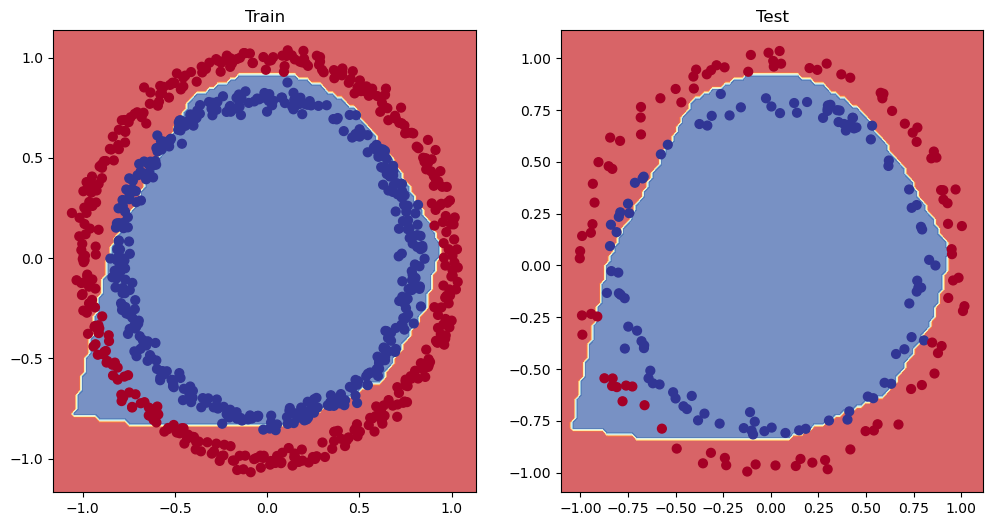

In [40]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

plt.show()

En el gráfico vemos que las regiones de decisión se ajustan mejor a la distribución de puntos

## Replicando non-linear activation functions

Nosotros, en lugar de decirle a la red neuronal qué tiene que aprender, le damos las herramientas para descubrir patrones en los datos para hacerlo por su cuenta. Estas herramientas son las funciones lineales y no lineales

### Relu

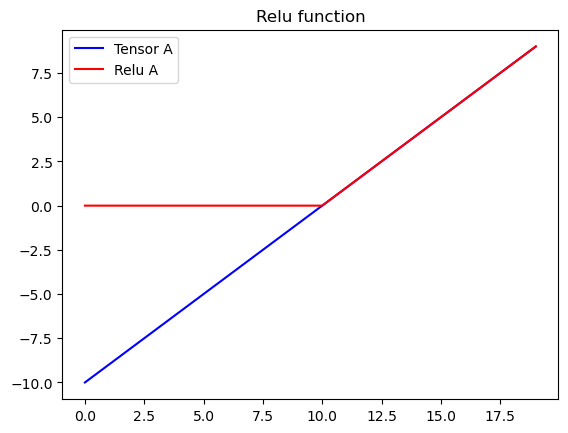

In [45]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)

A = torch.arange(-10, 10, 1, dtype=torch.float32)
relu_A = relu(A)

plt.plot(A, label="Tensor A", color="blue")
plt.plot(relu_A, label="Relu A", color="red")
plt.title("Relu function")
plt.legend()
plt.show()

### Sigmoid

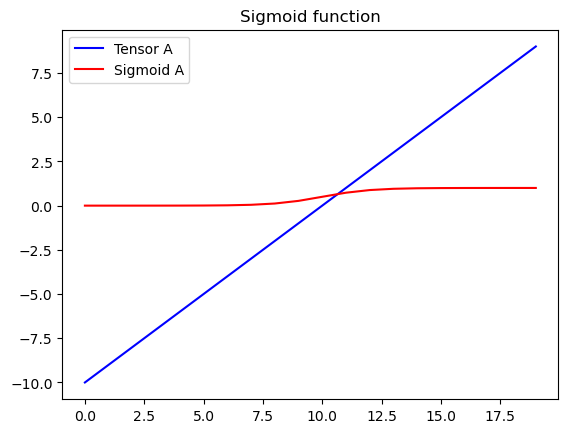

In [46]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))

s = sigmoid(A)

plt.plot(A, label="Tensor A", color="blue")
plt.plot(s, label="Sigmoid A", color="red")
plt.title("Sigmoid function")
plt.legend()
plt.show()